<a href="https://colab.research.google.com/github/asangphukieo/GWAS_workshop/blob/main/Notebook/01_GWAS_practicum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GWAS practicum
for Cancer Genomic Epidemiology workshop in Chiang Mai, Thailand (26 Feb - 1 Mar 2024)


## How to use this script?
#### updated 2024

1. All steps can be run on google colab with pre-installed R (https://colab.research.google.com/notebook#create=true&language=r)
2. Runing this script on server or local PC required R and PLINK installed.

# 1. Install PLINK

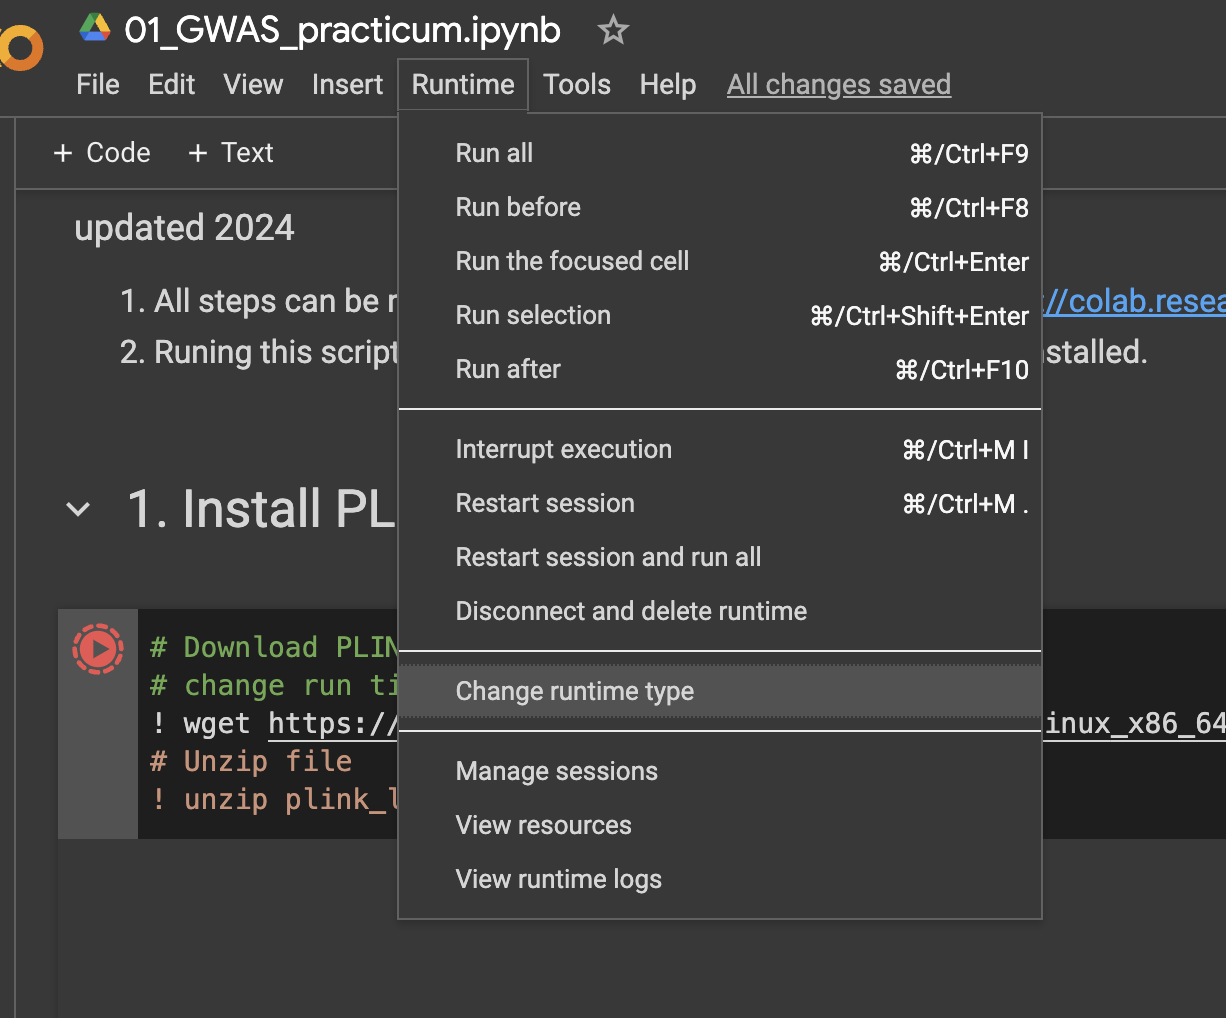

In [ ]:
# Download PLINK (bash cammand)
# change run time to python
! wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
# Unzip file
! unzip plink_linux_x86_64_20231211.zip

--2024-02-24 06:52:51--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.163.32, 52.217.227.152, 54.231.139.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.163.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8953953 (8.5M) [application/zip]
Saving to: ‘plink_linux_x86_64_20231211.zip’

plink_linux_x86_64_ 100%[===================>]   8.54M  5.01MB/s    in 1.7s    

2024-02-24 06:52:53 (5.01 MB/s) - ‘plink_linux_x86_64_20231211.zip’ saved [8953953/8953953]

Archive:  plink_linux_x86_64_20231211.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                


In [ ]:

# Successful PLINK installation
! ./plink --help

# 2. Download samples

In [ ]:
! wget https://github.com/asangphukieo/GWAS_workshop/raw/main/INPUT_GWAS/sample.bed
! wget https://github.com/asangphukieo/GWAS_workshop/raw/main/INPUT_GWAS/sample.bim
! wget https://github.com/asangphukieo/GWAS_workshop/raw/main/INPUT_GWAS/sample.fam
! wget https://github.com/asangphukieo/GWAS_workshop/raw/main/INPUT_GWAS/sample_phe.txt

--2024-02-24 06:53:05--  https://github.com/asangphukieo/GWAS_workshop/raw/main/INPUT_GWAS/sample.bed
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/asangphukieo/GWAS_workshop/main/INPUT_GWAS/sample.bed [following]
--2024-02-24 06:53:06--  https://raw.githubusercontent.com/asangphukieo/GWAS_workshop/main/INPUT_GWAS/sample.bed
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2499753 (2.4M) [application/octet-stream]
Saving to: ‘sample.bed’

sample.bed          100%[===================>]   2.38M  10.3MB/s    in 0.2s    

2024-02-24 06:53:07 (10.3 MB/s) - ‘sample.bed’ saved [2499753/2499753]

--2

# 2. Per-marker QC

## 2.1 Filter out variant with high missingness

In [ ]:

#count missing variants
! ./plink --bfile sample --missing --out miss
#output= miss.lmiss : Variant-based missing data report.
#output= miss.imiss : Sample-based missing data report.


ERROR: Error in parse(text = x, srcfile = src): <text>:3:19: unexpected symbol
2: #count missing variants
3: ! ./plink --bfile sample
                     ^


In [ ]:
! head miss.lmiss

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: ! head miss.lmiss
           ^


In [ ]:
! ./plink --bfile sample --geno 0.05 --make-bed --out miss

## 2.2 Filter out variant with MAF cutoff <5%

In [ ]:
#count AF
! ./plink --bfile miss --freq --make-bed --out freq
#output= freq.frq : Basic allele frequency report.

In [ ]:
! head freq.frq

In [ ]:
! ./plink --bfile miss --maf 0.05 --make-bed --out freq


## 2.3 Filter out variant with high Hardy-Weinberg disequilibrium

In [ ]:
! ./plink --bfile freq --hardy --make-bed --out hardy
#output= hardy.hwe : Hardy-Weinberg equilibrium exact test statistic report.

In [ ]:
! head hardy.hwe

In [ ]:
! ./plink --bfile freq --hwe 1e-5 --make-bed --out hardy

## 2.4 Filter out variants with high differential genotyping rate (case vs. control)

In [ ]:
#Check for differential genotyping rate (case vs. control)
! ./plink --bfile hardy --test-missing --out test_miss
# --test-missing tries to detect platform/batch differences between case and control genotype data by performing Fisher's exact test on case/control missing call counts at each variant.
# Any variant which comes up as highly significant under this test should be treated with great caution; spurious association results are likely.


In [ ]:
! head test_miss.missing

In [ ]:
# select variant with genotyping rate difference between case and control < 1e-2
! awk '$5 < 1e-2 {print $2}' test_miss.missing > test_mis_snp.ls

In [ ]:
! head test_mis_snp.ls

In [ ]:
#Exclude varinat in test_mis_snp.ls
! ./plink --bfile hardy --exclude test_mis_snp.ls --make-bed --out clean_snp


In [ ]:
# run all filters (Optional)
! ./plink --bfile sample --hwe 1e-5 \
--hwe-all --geno 0.05 --maf 0.05 \
--exclude test_mis_snp.ls \
--make-bed --out clean_snp --noweb

# 3. Per-Individual QC

## 3.1 Filter out individual with Genotyping rate per individual >5%

In [ ]:
! wc -l clean_snp.fam

1000 clean_snp.fam


In [ ]:
#Genotyping rate per individual with cutoff >5%
! ./plink --bfile clean_snp --mind 0.05 --make-bed --out clean_snp_indiv

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean_snp_indiv.log.
Options in effect:
  --bfile clean_snp
  --make-bed
  --mind 0.05
  --out clean_snp_indiv

12978 MB RAM detected; reserving 6489 MB for main workspace.
9949 variants loaded from .bim file.
1000 people (504 males, 496 females) loaded from .fam.
1000 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1000 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%

In [ ]:
! wc -l clean_snp_indiv.fam

1000 clean_snp_indiv.fam


## 3.2 Filter out duplicated or related individuals


In [ ]:
#identification of duplicated or related individuals (IBD=Identical By Descent)
! ./plink --bfile clean_snp_indiv --genome --out IBD

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to IBD.log.
Options in effect:
  --bfile clean_snp_indiv
  --genome
  --out IBD

12978 MB RAM detected; reserving 6489 MB for main workspace.
9949 variants loaded from .bim file.
1000 people (504 males, 496 females) loaded from .fam.
1000 phenotype values loaded from .fam.
Using up to 2 threads (change this with --threads).
Before main variant filters, 1000 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%

In [ ]:
! head IBD.genome

          FID1          IID1          FID2          IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
  KNIHGR003156  KNIHGR003156  KNIHGR008787  KNIHGR008787 UN    NA  0.9489  0.0511  0.0000  0.0255   0  0.714495  0.3650  1.9608
  KNIHGR003156  KNIHGR003156  KNIHGR007207  KNIHGR007207 UN    NA  0.9707  0.0189  0.0104  0.0198   0  0.718785  0.3031  1.9421
  KNIHGR003156  KNIHGR003156  KNIHGR008203  KNIHGR008203 UN    NA  1.0000  0.0000  0.0000  0.0000   0  0.713364  0.5302  2.0086
  KNIHGR003156  KNIHGR003156  KNIHGR003098  KNIHGR003098 UN    NA  0.9926  0.0000  0.0074  0.0074   0  0.715725  0.0754  1.8434
  KNIHGR003156  KNIHGR003156  KNIHGR004954  KNIHGR004954 UN    NA  0.9978  0.0000  0.0022  0.0022   0  0.714336  0.0127  1.7623
  KNIHGR003156  KNIHGR003156  KNIHGR007383  KNIHGR007383 UN    NA  0.9518  0.0482  0.0000  0.0241   0  0.714791  0.5228  2.0066
  KNIHGR003156  KNIHGR003156  KNIHGR002644  KNIHGR002644 UN    NA  1.0000  0.0000  0.0000  0.0000  -1  0

In [ ]:
! awk '$10 > 0.2' IBD.genome

          FID1          IID1          FID2          IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
  KNIHGR003156  KNIHGR003156  KNIHGR000056  KNIHGR000056 UN    NA  0.5521  0.4389  0.0091  0.2285  -1  0.763561  1.0000  4.1260
  KNIHGR004166  KNIHGR004166  KNIHGR001095  KNIHGR001095 UN    NA  0.6134  0.3659  0.0207  0.2036   1  0.759031  1.0000  3.3808
  KNIHGR001095  KNIHGR001095  KNIHGR000202  KNIHGR000202 UN    NA  0.4339  0.5661  0.0000  0.2831   1  0.770740  1.0000  5.0431
  KNIHGR005309  KNIHGR005309  KNIHGR007641  KNIHGR007641 UN    NA  0.4376  0.5533  0.0091  0.2858   0  0.775873  1.0000  6.2584
  KNIHGR006800  KNIHGR006800  KNIHGR002884  KNIHGR002884 UN    NA  0.4660  0.5261  0.0079  0.2709   1  0.772594  1.0000  5.1028


In [ ]:
! awk '$10 > 0.2 {print $1"\t"$2}' IBD.genome | tail -n+2> IBD_prob.rm

In [ ]:
! head IBD_prob.rm

KNIHGR003156	KNIHGR003156
KNIHGR004166	KNIHGR004166
KNIHGR001095	KNIHGR001095
KNIHGR005309	KNIHGR005309
KNIHGR006800	KNIHGR006800


In [ ]:
! ./plink --bfile clean_snp_indiv --remove IBD_prob.rm --make-bed --out clean_snp_ibd

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean_snp_ibd.log.
Options in effect:
  --bfile clean_snp_indiv
  --make-bed
  --out clean_snp_ibd
  --remove IBD_prob.rm

12978 MB RAM detected; reserving 6489 MB for main workspace.
9949 variants loaded from .bim file.
1000 people (504 males, 496 females) loaded from .fam.
1000 phenotype values loaded from .fam.
--remove: 995 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 995 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57

In [ ]:
! wc -l clean_snp_ibd.fam

995 clean_snp_ibd.fam


In [ ]:
# run all filters at once (Optional)
! ./plink --bfile clean_snp --mind 0.05 \
 --remove IBD_prob.rm \
 --make-bed --out clean_snp_ibd

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean_snp_ibd.log.
Options in effect:
  --bfile clean_snp
  --make-bed
  --mind 0.05
  --out clean_snp_ibd
  --remove IBD_prob.rm

12978 MB RAM detected; reserving 6489 MB for main workspace.
9949 variants loaded from .bim file.
1000 people (504 males, 496 females) loaded from .fam.
1000 phenotype values loaded from .fam.
--remove: 995 people remaining.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 995 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%

In [ ]:
! wc -l clean_snp_ibd.fam

995 clean_snp_ibd.fam


# 3.3 Generate PCA to adjust for population structure


In [ ]:
# calculate pca
! ./plink --bfile clean_snp_ibd --pca 10 --out clean_snp_pca

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean_snp_pca.log.
Options in effect:
  --bfile clean_snp_ibd
  --out clean_snp_pca
  --pca 10

12978 MB RAM detected; reserving 6489 MB for main workspace.
9949 variants loaded from .bim file.
995 people (501 males, 494 females) loaded from .fam.
995 phenotype values loaded from .fam.
Using up to 2 threads (change this with --threads).
Before main variant filters, 995 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%6

In [ ]:
! head clean_snp_pca.eigenvec

KNIHGR008787 KNIHGR008787 -0.0324963 -0.0207412 -0.00552407 -0.00710313 -0.00827216 0.0151119 0.090792 0.00721162 -0.0175097 0.0171698
KNIHGR007207 KNIHGR007207 0.0349111 -0.0204404 -0.00525774 -0.00277024 -0.0306511 0.0553649 -0.0311411 -0.0314864 0.0615983 0.0158347
KNIHGR008203 KNIHGR008203 -0.00229467 0.0498351 0.022488 -0.0660986 0.00450342 0.0667524 0.010693 0.0247938 0.0313279 0.0130719
KNIHGR003098 KNIHGR003098 -0.000701445 -0.0230102 -0.0839422 0.033572 -0.0261344 -0.0164958 0.00866423 -0.0105708 0.00199696 0.0510621
KNIHGR004954 KNIHGR004954 0.0593473 -0.0119685 0.0320478 -0.0124945 0.00586416 -0.0283022 -0.00449577 -0.00549705 -0.0149497 0.0322169
KNIHGR007383 KNIHGR007383 -0.0218179 -0.00840755 0.0174632 -0.0162591 -0.0289075 -0.0114462 -0.00436629 -0.010749 -0.0358571 -0.000232513
KNIHGR002644 KNIHGR002644 0.039575 -0.0101308 -0.026406 -0.0421134 -0.0186574 -0.00718034 -0.0253002 -0.0146535 -0.0278193 -0.0196859
KNIHGR003605 KNIHGR003605 0.0399602 -0.0385095 0.0322037 0.06

In [ ]:
# plot PC1 vs PC2

In [ ]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Swich to R session

In [ ]:
# Load necessary libraries

library(ggplot2)
library(data.table)

# Load PLINK PCA output
pca_data <- fread("clean_snp_pca.eigenvec", header = FALSE)

# Load phenotype file
phenotype <- fread("clean_snp_ibd.fam", header = FALSE)

# Merge PCA data with phenotype data
merged_data <- merge(pca_data, phenotype, by.x = "V2", by.y = "V2")
head(merged_data)


V2,V1.x,V3.x,V4.x,V5.x,V6.x,V7,V8,V9,V10,V11,V12,V1.y,V3.y,V4.y,V5.y,V6.y
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>
KNIHGR000005,KNIHGR000005,0.0142763,0.0056749,0.01558230,-0.01404220,0.0243185,0.01280650,0.05570950,-0.01135810,0.0323003,-0.05238910,KNIHGR000005,0,0,2,1
KNIHGR000007,KNIHGR000007,-0.0313624,-0.0184620,0.10048700,-0.07568240,0.0274083,0.05827180,0.03930850,0.01669470,-0.0156958,0.00415943,KNIHGR000007,0,0,2,1
KNIHGR000014,KNIHGR000014,0.0186193,0.0533010,-0.00471771,0.01527580,-0.0125388,-0.00648545,0.04178690,-0.01761800,-0.0138985,0.04156320,KNIHGR000014,0,0,1,1
KNIHGR000017,KNIHGR000017,-0.0285034,0.0197182,0.00831315,-0.00251558,-0.0148766,0.00658800,0.03259850,-0.01223250,0.0176891,0.04796230,KNIHGR000017,0,0,1,2
KNIHGR000021,KNIHGR000021,0.0365054,0.0066753,-0.00814724,-0.01611610,-0.0245043,-0.00571347,0.03898290,-0.00986972,0.0449646,0.01141470,KNIHGR000021,0,0,1,2
KNIHGR000035,KNIHGR000035,0.0513494,-0.0534350,-0.08795960,0.02321980,0.0142529,-0.01065310,-0.00156583,-0.04385000,0.0481552,-0.00301195,KNIHGR000035,0,0,1,1


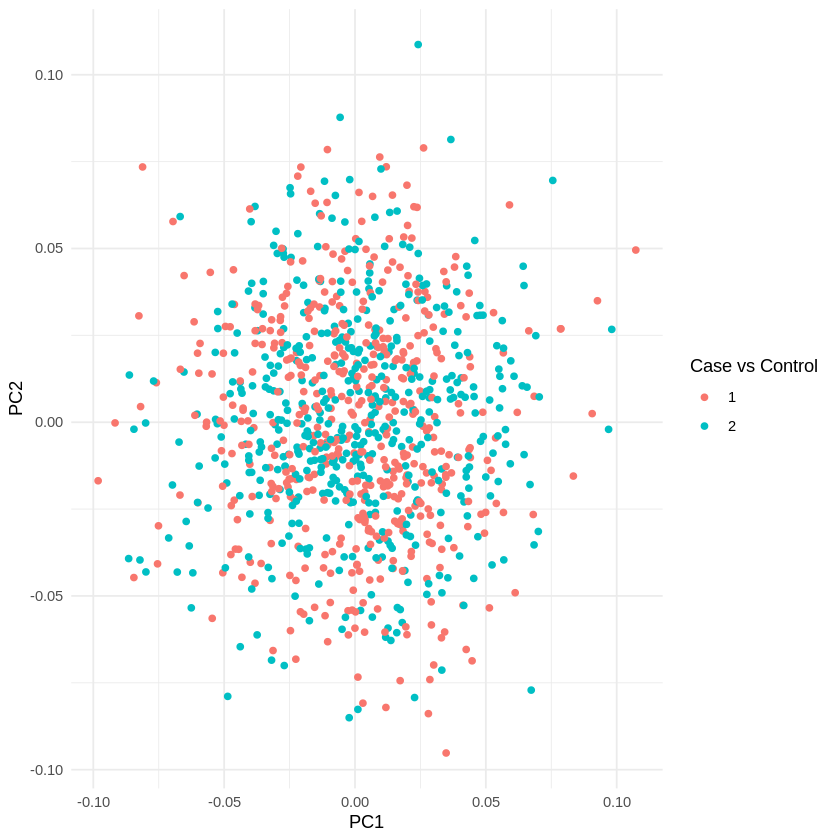

In [ ]:
# Plot PCA with color representing case/control status
ggplot(merged_data, aes(x = V3.x, y = V4.x, color = factor(V6.y))) +
  geom_point() +
  labs(x = "PC1", y = "PC2", color = "Case vs Control") +
  theme_minimal()

# 4. Running logistic regression test
### switch to bash command

In [ ]:
#Running logistic regression by plink (Covariate : intercept, sex, age,age2, pc1~ pc10 )
! ./plink --bfile clean_snp_ibd --logistic --covar sample_phe.txt --covar-name sex,age,PC1-PC10 --parameters 1 --out logistic

#Adjusting the multiple testing problem
! ./plink --bfile clean_snp_ibd --logistic --covar sample_phe.txt --covar-name sex,age,PC1-PC10 --parameters 1 --out logistic --adjust


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to logistic.log.
Options in effect:
  --bfile clean_snp_ibd
  --covar sample_phe.txt
  --covar-name sex,age,PC1-PC10
  --logistic
  --out logistic
  --parameters 1

12978 MB RAM detected; reserving 6489 MB for main workspace.
9949 variants loaded from .bim file.
995 people (501 males, 494 females) loaded from .fam.
995 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
--covar: 12 out of 13 covariates loaded.
Before main variant filters, 995 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%

In [ ]:
! head logistic.assoc.logistic

 CHR          SNP         BP   A1       TEST    NMISS         OR         STAT            P 
   1   rs11730743    2924172    C        ADD      995     0.9411      -0.5193       0.6035
   1    rs5000660    3227034    G        ADD      995     0.9146      -0.9603       0.3369
   1    rs2936507    4036902    C        ADD      993      1.075       0.4642       0.6425
   1   rs10926659    4280876    G        ADD      994     0.8724      -0.9442       0.3451
   1   rs10878298    4381492    G        ADD      976     0.9782      -0.1746       0.8614
   1    rs1504600    4459761    T        ADD      995      1.002      0.01606       0.9872
   1    rs1447552    4887284    G        ADD      995     0.8362       -1.964      0.04954
   1    rs9759081    5209527    G        ADD      995      1.006      0.05946       0.9526
   1    rs7233624    5224091    A        ADD      995     0.9512       -0.506       0.6128


In [ ]:
! head logistic.assoc.logistic.adjusted

 CHR          SNP      UNADJ         GC       BONF       HOLM   SIDAK_SS   SIDAK_SD     FDR_BH     FDR_BY
   5   rs11914379   7.69e-05   7.69e-05     0.7651     0.7651     0.5347     0.5347     0.5244          1 
   7    rs2060888  0.0001054  0.0001054          1          1     0.6497     0.6496     0.5244          1 
   1   rs11048030  0.0003091  0.0003091          1          1     0.9539     0.9538     0.5762          1 
   7    rs1046896  0.0003132  0.0003132          1          1     0.9557     0.9556     0.5762          1 
   4   rs13113975  0.0003162  0.0003162          1          1      0.957     0.9569     0.5762          1 
  13    rs7517036  0.0003612  0.0003612          1          1     0.9725     0.9725     0.5762          1 
   1    rs6542822  0.0004255  0.0004255          1          1     0.9855     0.9855     0.5762          1 
  18   rs16850885  0.0004633  0.0004633          1          1     0.9901       0.99     0.5762          1 
   6   rs10994863  0.0006581  0.000658

# 5. Create Manhattan Plot and QQ plot with R
### switch to R session


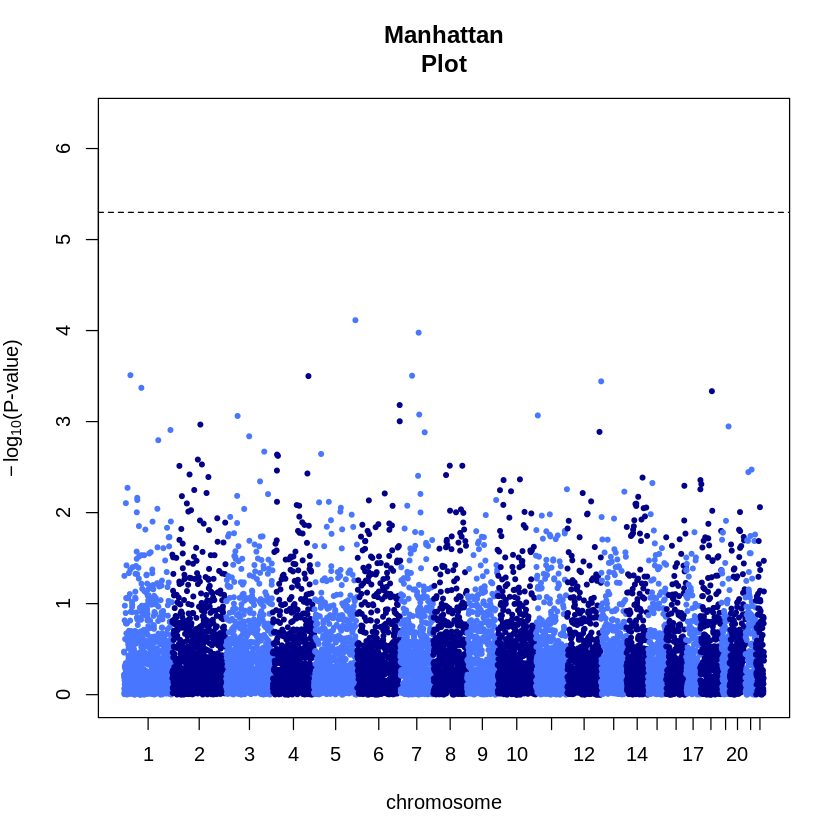

In [ ]:
# R session

mhtdata <- read.table('logistic.assoc.logistic',header=T) #change from sample.assoc to logistic.assoc.logistic
data2 <- mhtdata[!apply(is.na(mhtdata), 1, any), ]
oo <-order(data2$CHR)
data2 <-data2[oo,]
chrlabel_pos <- allchr <- as.vector(table(data2$CHR))
n.chr <- length(allchr)
chrindex<- cumsum(allchr)
labels <- unique(data2$CHR)
pos <- newpos<-data2$BP
chr_colors <- rep(c("royalblue1","blue4"),11)

for (i in 1:n.chr) {
        endP <- chrindex[i]
        stP <- chrindex[i] - allchr[i] + 1
        d <- rep(1, allchr[i])
        newpos[stP:endP] <- d
}
CM <- cumsum(as.numeric(newpos))
Y <- -log(data2$P,10)

#png('manh.png',width=2000,height=1000,units="px",bg="white",res=200)

if(max(Y) < -log10(0.05/length(Y))) {
       plot(CM, Y, type="n",xaxt="n", xlab="chromosome",
ylab=expression(paste(-log[10],"(P-value)") ), main="Manhattan
Plot",ylim=c(0,-log10(0.05/length(Y))+1))
} else {
plot(CM, Y, type="n",xaxt="n", xlab="chromosome", ylab=expression(paste(-log[10],"(P-value)") ), main="Manhattan Plot")
}

for (i in 1:n.chr) {
        u <- chrindex[i]
        l <- chrindex[i] - allchr[i] + 1
        chr <- l:u
        y <- -log(data2$P[chr], 10)
        points(CM[chr], y, col = chr_colors[i],
		cex = 0.8, pch=20)
		midchr<- chrindex[i] - allchr[i]/2 + 1
		chrlabel_pos[i] <-CM[midchr]
}
axis(1, at = chrlabel_pos, labels = labels)
abline(h=-log10(0.05/length(Y)),lty=2)
#dev.off()




[1] 4.114074

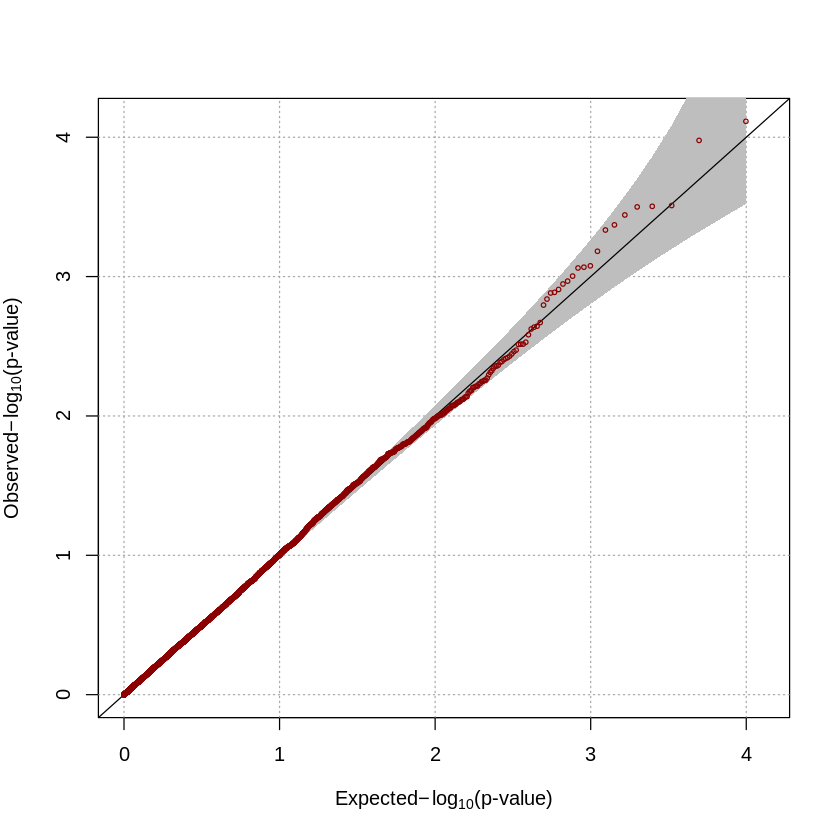

In [ ]:
#QQ plot
## Calculate X and Y
p.val <- data2$P
y <- -log(p.val,10)
v <- -log10(0.05/sum(is.finite(y)))
o.y <- sort(y[is.finite(y)],decreasing=T)
xx<- (1:length(o.y))/length(o.y)
x <- -log(xx,10)
ifelse(max(o.y[is.finite(o.y)])>=x[1],YY<-o.y,YY<-x)
## plot ##
#png('QQplot.png',width=1000,height=1000,units="px",bg="white",res=200)
plot(YY, YY, type = "n", xlab = expression(paste("Expected",-log[10],"(p-value)")), ylab = expression(paste("Observed",-log[10],"(p-value)")))

N=length(o.y)
c95 <- rep(0,N)
c05 <- rep(0,N)
for(i in 1:N){
       c95[i] <- qbeta(0.95,i,N-i+1)
       c05[i] <- qbeta(0.05,i,N-i+1)
}
abline(h = c(0:max(max(x),max(o.y[is.finite(o.y)]))), v =c(0:max(max(x),max(o.y[is.finite(o.y)]))), col = "darkgray", lty=3)
polygon(c(x,sort(x)),c(-log(c95,10),sort(-log(c05,10))),col=c("gray"),border=NA)
abline(a=0,b=1,col="black", lty=1)
points(x, o.y, cex = .5, col = "dark red")
#dev.off()

# END R Session #